# Preprocessing Training Data

The Ground Truth masks are a bit problematic, because often only one of multiple grains are included in the ground truth mask.
There are some events of the same image being present twice, with two different ground truth masks.
This notebook will look at finding these duplicate images and combining the masks into one.

## To Do
1. Create list of patient ID (duplicate images will always belong to the same patient as eachother).
1. Search through images of each patient, checking for duplicates.
1. If there is a duplicate, combine the masks, overwrite the mask, and delete the second image/mask occurrence.

In [36]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import cv2
import sys

sys.path.append('../src')
from utils import return_image_and_mask, return_image, return_mask, plot_image_and_mask

In [2]:
!ls ../data/

data.md            training_dataset   validation_dataset
train.tar.gz       valid.tar.gz


In [3]:
DATA_DIR = '../data'

In [4]:
# Get full image path by adding filename to base path

# Get the paths
train_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/training_dataset/**/*.jpg')])
val_paths = np.array([os.path.relpath(i, DATA_DIR).split('.')[0] for i in glob.glob(f'{DATA_DIR}/validation_dataset/**/*.jpg')])

print(f"Train length: {len(train_paths)}")
print(f"Val length: {len(val_paths)}")

Train length: 593
Val length: 91


In [5]:
# Sort paths to make sorting by patient easier
train_paths.sort()
val_paths.sort()

In [26]:
idx = 70
print(train_paths[idx:idx+10])

['training_dataset/BM/BM32_1' 'training_dataset/BM/BM32_2'
 'training_dataset/BM/BM32_3' 'training_dataset/BM/BM32_4'
 'training_dataset/BM/BM32_5' 'training_dataset/BM/BM33_1'
 'training_dataset/BM/BM35_1' 'training_dataset/BM/BM35_2'
 'training_dataset/BM/BM35_3' 'training_dataset/BM/BM35_4']


In [7]:
# Function to split path and return only the patient code (e.g. BM10)
def get_patient_id(path):
    
    # First take final part of the path, then take everything before the underscore
    patient_id = path.split('/')[2].split('_')[0]
    return patient_id

In [10]:
get_patient_id(train_paths[0])

'BM10'

In [11]:
train_patient_ids = list(set([get_patient_id(path) for path in train_paths]))

In [12]:
train_patient_ids

['FM50',
 'FM68',
 'BM67',
 'FM35',
 'FM57',
 'BM52',
 'FM70',
 'FM41',
 'FM14',
 'BM48',
 'BM13',
 'BM9',
 'BM5',
 'FM66',
 'FM72',
 'BM37',
 'FM22',
 'BM38',
 'FM44',
 'FM94',
 'BM36',
 'FM45',
 'BM50',
 'FM26',
 'BM24',
 'FM64',
 'FM18',
 'FM21',
 'FM1',
 'BM11',
 'FM3',
 'FM96',
 'FM99',
 'FM97',
 'BM63',
 'BM4',
 'FM88',
 'BM33',
 'FM84',
 'FM47',
 'FM80',
 'BM35',
 'BM10',
 'BM69',
 'FM17',
 'BM46',
 'BM49',
 'BM55',
 'BM43',
 'BM19',
 'BM23',
 'FM43',
 'FM58',
 'BM17',
 'BM41',
 'BM64',
 'FM85',
 'FM63',
 'BM6',
 'FM7',
 'BM57',
 'FM20',
 'BM59',
 'BM15',
 'FM13',
 'FM89',
 'BM65',
 'FM48',
 'BM47',
 'FM32',
 'BM66',
 'FM24',
 'FM60',
 'FM54',
 'BM45',
 'BM20',
 'FM49',
 'FM16',
 'BM44',
 'BM32',
 'BM3',
 'FM23',
 'BM30',
 'BM54',
 'BM60',
 'BM31',
 'FM65',
 'FM28',
 'FM46']

In [12]:
# For a given patient, print out all images and masks
def get_patient_paths(paths, patient_id):
    patient_paths = [path for path in paths if patient_id in path]
    return patient_paths

PATIENT: FM45
training_dataset/FM/FM45_1


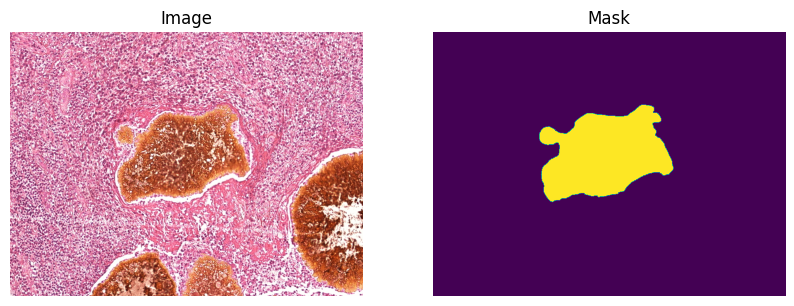

training_dataset/FM/FM45_10


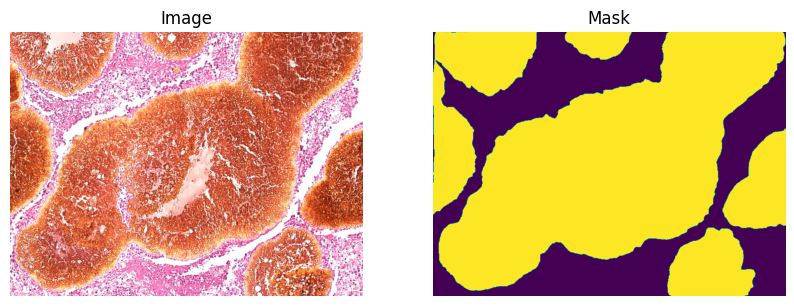

training_dataset/FM/FM45_2


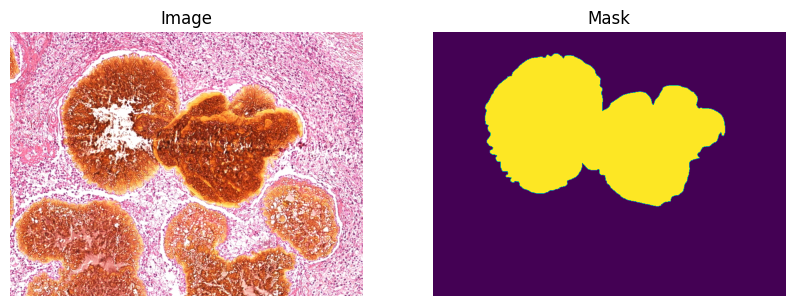

training_dataset/FM/FM45_3


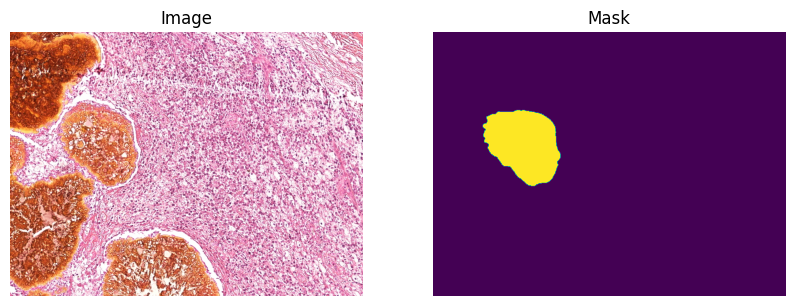

training_dataset/FM/FM45_4


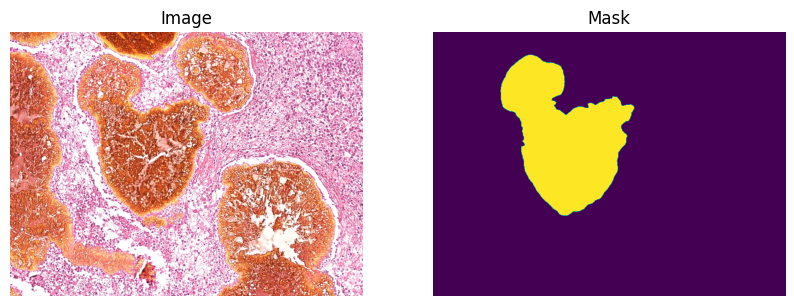

training_dataset/FM/FM45_5


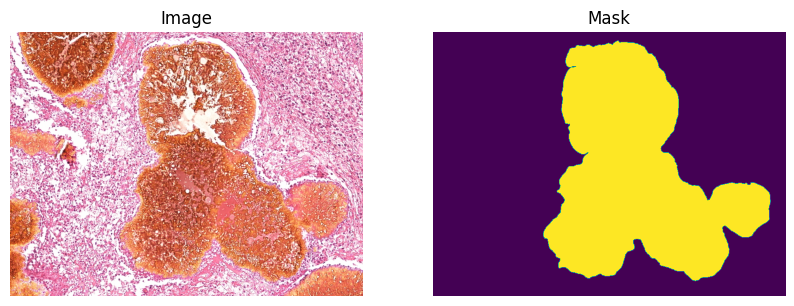

training_dataset/FM/FM45_6


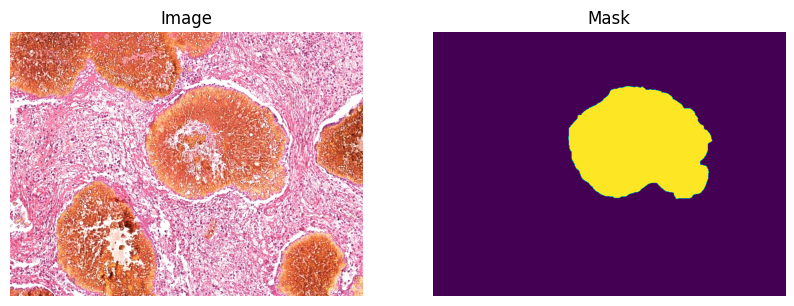

training_dataset/FM/FM45_7


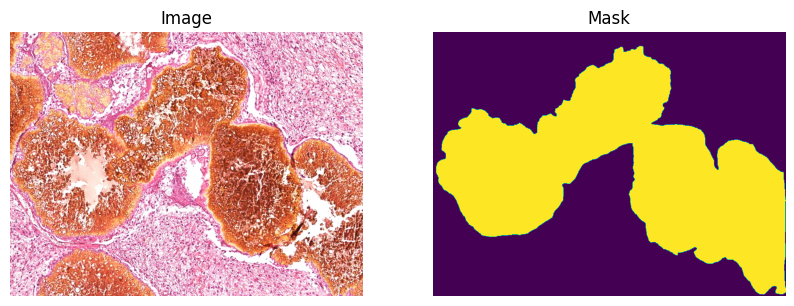

training_dataset/FM/FM45_8


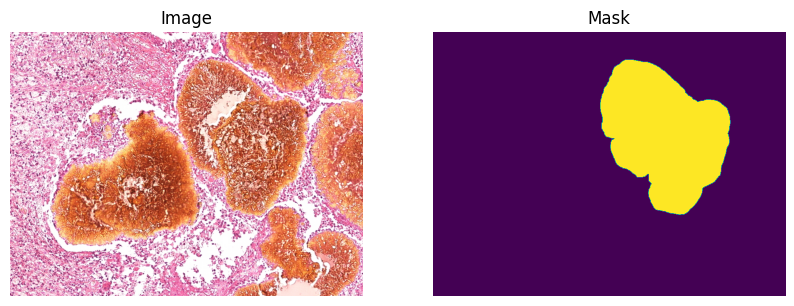

training_dataset/FM/FM45_9


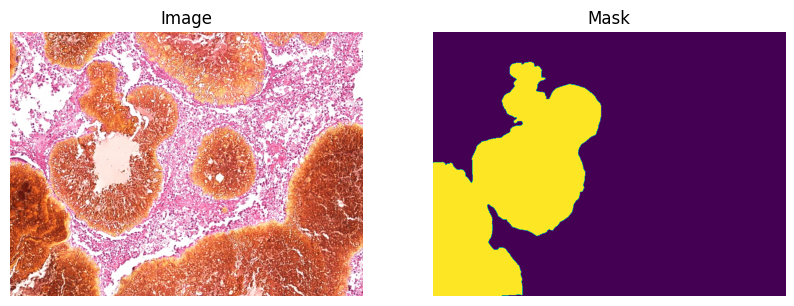

In [24]:
patient_id = train_patient_ids[0]
print(f'PATIENT: {patient_id}')
patient_paths = get_patient_paths(train_paths, patient_id)
for path in patient_paths:
    print(path)
    plot_image_and_mask(path)

In [14]:
# Function to match features of two images
# To be used as part of process to check if two images share an overlapping region
def detect_and_match_features(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # Detect ORB features and compute descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)
    
    # Match descriptors using BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)
    
    return keypoints1, keypoints2, matches

In [15]:
# After keypoints and matches of two images have been calculated,
# this function takes the mean of the top 10 match translations 
def estimate_translation(keypoints1, keypoints2, matches):
    
    # Calculate the translation vector
    translations = []

    for match in matches[:10]:
            pt1 = keypoints1[match.queryIdx].pt
            pt2 = keypoints2[match.trainIdx].pt
            translations.append((pt2[0] - pt1[0], pt2[1] - pt1[1]))

    translations = np.array(translations)
    median_translation = np.rint(np.median(translations, axis=0))

    return median_translation

# Function to apply x-y translation to an image
def translate_image(image, translation):

    rows, cols = image.shape[:2]
    translation = (-translation[0], -translation[1])
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))

    return translated_image

In [16]:
# Once an image has been translated, find the span of the nonzero part (the overlap part)
def find_overlap_bbox(image):

    # Find coordinates of all non-zero pixels
    coords = cv2.findNonZero(image[...,0])
    
    # Calculate the bounding box of the non-zero region
    x, y, w, h = cv2.boundingRect(coords)
    min_x, min_y, max_x, max_y = x, y, x + w, y + h

    return min_x, min_y, max_x, max_y

In [17]:
## VISUALISATION FUNCTIONS

# Plot to show matched features between two images
def visualize_matches(image1, image2, keypoints1, keypoints2, matches):
    matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(15, 10))
    plt.title('Matched Features')
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.show()

# Plot to show images before and after translation
def visualize_translation(image1, image2, translated_image2):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image 1')
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 2)
    plt.title('Original Image 2')
    plt.imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    
    plt.subplot(1, 3, 3)
    plt.title('Translated Image 2')
    plt.imshow(cv2.cvtColor(translated_image2, cv2.COLOR_BGR2RGB))
    
    plt.show()

# Plot to show the difference between the first image and the translated second image
def visualize_difference(image1, translated_image2):
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(translated_image2, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray1, gray2)
    
    plt.figure(figsize=(10, 5))
    plt.title('Difference Image')
    plt.imshow(difference, cmap='hot')
    plt.show()

In [18]:
def check_overlap(image1, image2, visualize=True):
    # Detect and match features
    keypoints1, keypoints2, matches = detect_and_match_features(image1, image2)
    
    # Estimate translation
    translation = estimate_translation(keypoints1, keypoints2, matches)
    
    # Translate the second image
    translated_image2 = translate_image(image2, translation)
    
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(translated_image2, cv2.COLOR_BGR2GRAY)

    # Crop both to matching region
    xl,yl,xh,yh = find_overlap_bbox(translated_image2)
    crop1 = gray1[yl:yh,xl:xh]
    crop2 = gray2[yl:yh,xl:xh]

    # Gaussian Blur before measuring difference to reduce alignment error
    blurred_crop1 = cv2.GaussianBlur(crop1, (11, 11), 0)
    blurred_crop2 = cv2.GaussianBlur(crop2, (11, 11), 0)
    
    # Compute absolute difference between images
    diff = cv2.absdiff(blurred_crop1, blurred_crop2)

    # Threshold the difference image
    threshold_val = 40
    _, thresh = cv2.threshold(diff, threshold_val, 255, cv2.THRESH_BINARY)

    if visualize:
        # Visualize matched features
        visualize_matches(image1, image2, keypoints1, keypoints2, matches)

        # Visualize translation result
        visualize_translation(image1, image2, translated_image2)

        # Visualise difference between matching areas
        plt.title('Difference')
        plt.imshow(diff, cmap='hot')
        plt.show()

        # And when threshold is applied
        plt.title(f'thresholded at {threshold_val}')
        plt.imshow(thresh)
        plt.show()

    # Calculate percentage of overlap
    overlap = np.count_nonzero(thresh == 0) / np.size(thresh)

    return overlap

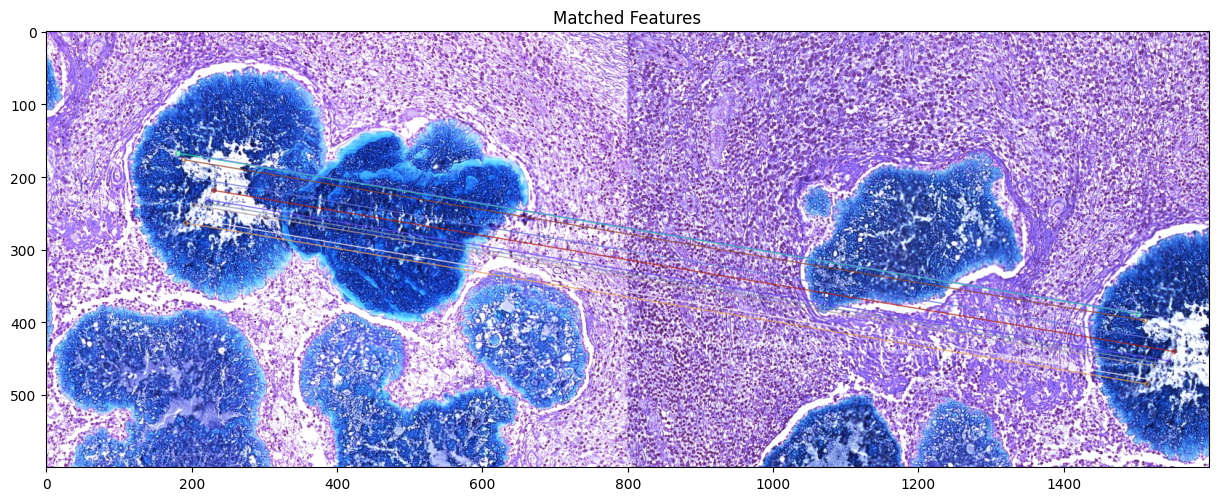

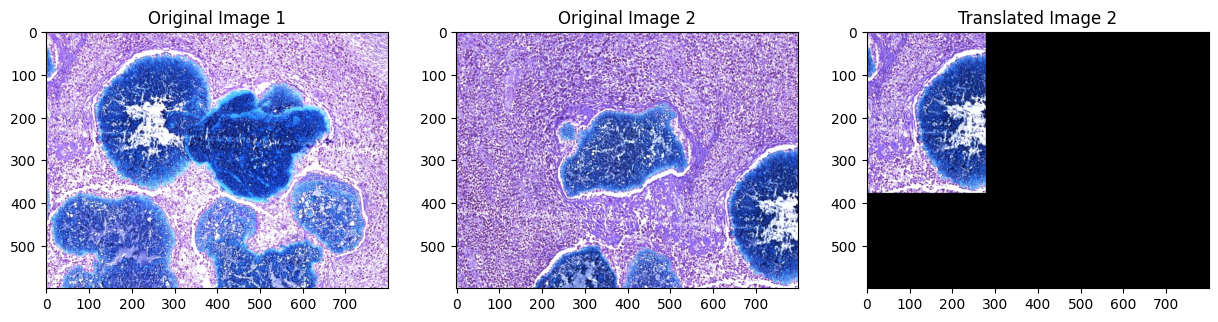

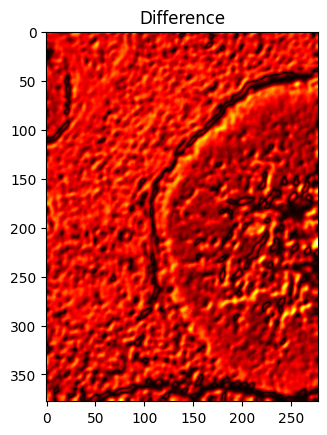

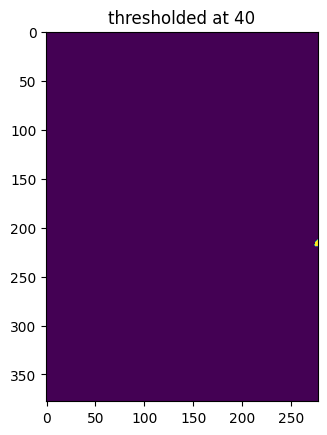

0.9998191922652354

In [28]:
patient = train_patient_ids[2]
paths = get_patient_paths(train_paths, patient)

# Load your images
image1, _ = return_image_and_mask(DATA_DIR, paths[2])
image2, _ = return_image_and_mask(DATA_DIR, paths[0])

check_overlap(image1, image2)

In [ ]:
# Let's check if this works:

match_count = 0

# cycle through patients
for patient in train_patient_ids:
    
    patient_paths = get_patient_paths(train_paths, patient)

    # cycle through paths
    for path1 in patient_paths:
        image1, mask1 = return_image_and_mask(DATA_DIR, path1)

        # Check all paths in list
        for path2 in patient_paths[:10]:
            if path1 == path2:
                continue
            
            image2, mask2 = return_image_and_mask(DATA_DIR, path2)

            if (image1==image2).all():
                continue
            
            overlap = check_overlap(image1, image2, visualize=False)
            #print(f'{path1} and {path2} have Overlap percentage: {overlap * 100:.2f}%')
            if overlap > 0.9:
                print("We Got a Match !! :)")
                print(f'Between {path1} and {path2}')

                fig, ax = plt.subplots(2, 2, figsize=(10, 5))

                ax[0][0].imshow(image1)
                ax[0][0].set_title('Image1')
                ax[0][0].axis('off')

                ax[0][1].imshow(image2)
                ax[0][1].set_title('Image2')
                ax[0][1].axis('off')

                ax[1][0].imshow(mask1)
                ax[1][0].set_title('Mask1')
                ax[1][0].axis('off')

                ax[1][1].imshow(mask2)
                ax[1][1].set_title('Mask2')
                ax[1][1].axis('off')

                plt.show()

                match_count += 0.5 # matching both ways at the moment
                print(f'Matches so far: {np.ceil(match_count)}')

            

